In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [43]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
print(most_recent_date)


2017-08-23 00:00:00


In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year = most_recent_date  - dt.timedelta(days=365)
# print(last_year)
# our range is 2016-08-23 to 2017-08-23 

# Perform a query to retrieve the data and precipitation scores
prcp_results = (
    session.query(measurement.date, measurement.prcp)
    .filter(measurement.date > last_year)
    .order_by(measurement.date)
    .all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=["Date", "Precipitation"])

# Sort the dataframe by date
prcp_df["Date"] = pd.to_datetime(prcp_df["Date"])
prcp_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


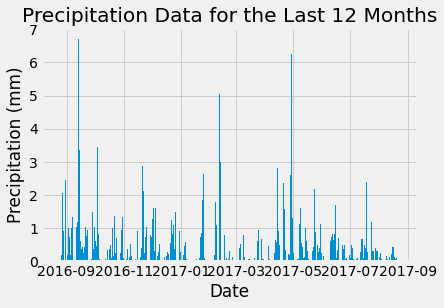

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
x = prcp_df["Date"]
y= prcp_df["Precipitation"]
plt.bar(x, y)
#Format the Bar Chart
# color="teal", figsize=(5,5))
plt.title("Precipitation Data for the Last 12 Months")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Date")
plt.savefig("Precipitation Data for the Last 12 Months")



In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(station).count()
print(f"The Number of Stations is {stations_count}")

The Number of Stations is 9


In [44]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.v
active_stations = (
    session.query(measurement.station, station.name, func.count(measurement.id))
    .filter(measurement.station == station.station)
    .group_by(measurement.station)
    .order_by(func.count(measurement.id).desc())
    .all()
)
print("The most active  stations are:")
pprint(active_stations)

The most active  stations are:
[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_record = (
    session.query(
        func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs),
    )
    .filter(measurement.station == active_stations[0][0])
    .all()
)
print(f"The most active station is {active_stations[0],[0]} - {active_stations[0][1]}. Statistics are:")
print(f"Lowest Temperature: {station_record[0][0]}°F")
print(f"Highest Temperature: {station_record[0][1]}°F")
print(f"Average Temperature: {station_record[0][2]}°F")

The most active station is (('USC00519281', 'WAIHEE 837.5, HI US', 2772), [0]) - WAIHEE 837.5, HI US. Statistics are:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


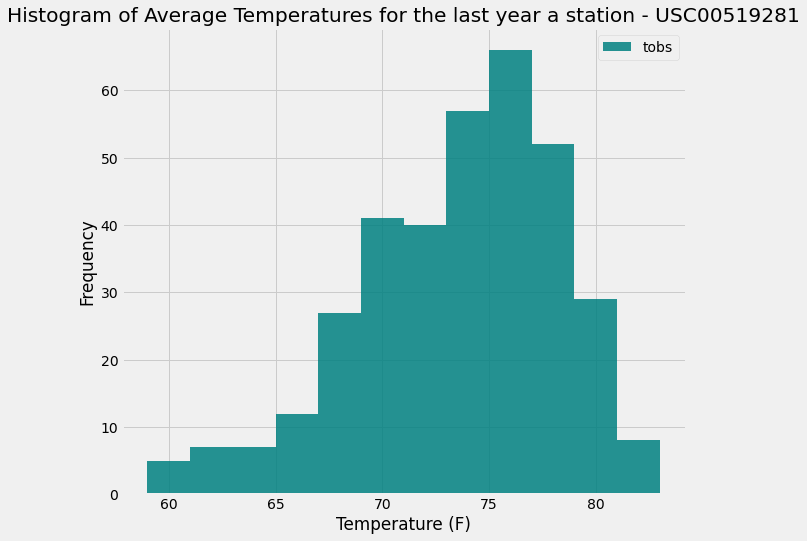

In [59]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_results = (
    session.query(measurement.date, measurement.tobs)
    .filter(measurement.date > last_year)
    .filter(measurement.station == active_stations[0][0])
    .order_by(measurement.date)
    .all()
)

#Converting query to a dataframe to prepare for the histogram
temperature_df = pd.DataFrame(temperature_results)
temperature_df = temperature_df.set_index("date").sort_index(ascending = True)

#check the dataframe
# temperature_df.head()

#Create the Histogram plot
temperature_df.plot(kind="hist", color="teal", bins=12, alpha=0.85, figsize=(9,8))
plt.title(f"Histogram of Average Temperatures for the last year a station - {active_stations[0][0]}")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.savefig("station_histogram.png")

# Close session

In [60]:
# Close Session
session.close()